In [1]:
import time
from tqdm.notebook import trange, tqdm
import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from data import JsonDataset, get_samplers
from data import domain, split_data
from torch.utils.data.sampler import SubsetRandomSampler
from copy import deepcopy
import pandas as pd
import numpy as np

import logomaker
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
USE_CUDA = True

## Model Hyperparameters

In [3]:
CONFIG = {
   "learning_rate": 0.00010229218879330196,
   "weight_decay": 0.0016447149582678627,
   "xt_hidden": 1024,
   "seq_length": 1000,
   "conv1_ksize": 9,
   "conv1_knum": 256,
   "pool1": 19,
   "conv2_ksize": 13,
   "conv2_knum": 64,
   "pool2": 8,
   "batch_size": 256,
   "conv_activation" : "relu",
   "fc_activation" : "elu",
   "conv_dropout": 0.3981796388676127,
   "tf_dropout": 0.18859739941162465,
   "fc_dropout": 0.016570328292903613,
   "use_cuda": USE_CUDA,
   "prefix":'sc_elem_',
   "num_tfs":208
}

## Device Setup

In [4]:
if USE_CUDA:
    print("using gpu")
    cuda = torch.device('cuda')
    FloatTensor = torch.cuda.FloatTensor
    LongTensor = torch.cuda.LongTensor
    def cudaify(model):
        return model.cuda()
else: 
    print("using cpu")
    cuda = torch.device('cpu')
    FloatTensor = torch.FloatTensor
    LongTensor = torch.LongTensor
    def cudaify(model):
        return model

using gpu


## Classes

In [5]:
class Vocab:
    """
    A simple vocabulary class that takes an alphabet of symbols,
    and assigns each symbol a unique integer id., e.g.
    
    > v = Vocab(['a','b','c','d'])
    > v('c')
    2
    > v('a')
    0
    > len(v)
    4
    
    """
    def __init__(self, alphabet):
        self.alphabet = alphabet
        self.index_map = {letter: index for (index, letter) in 
                          list(enumerate(alphabet))}
        
    def __len__(self):
        return len(self.alphabet)
        
    def __call__(self, letter):
        return self.index_map[letter]

In [6]:
class PandasDataset(Dataset):

    def __init__(self, pd_file):
        self.data = pd.read_pickle(pd_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data.loc[idx].to_dict()

    def select(self, field):
        for i, datum in self.data.iterrows():
            yield datum[field]

In [7]:
class Tensorize:
    """
    An instance of Tensorize is a function that maps a piece of data
    (i.e. a dictionary) to an input and output tensor for consumption by
    a neural network.
    """
    
    def __init__(self, symbol_vocab, max_word_length):
        self.symbol_vocab = symbol_vocab
        self.max_word_length = max_word_length
    
    def __call__(self, data):
        words = Tensorize.words_to_tensor(data['seq'], 
                                              self.symbol_vocab, 
                                              self.max_word_length).float()
        
        tfs = torch.stack(data['tfs'],dim=1).float()
        label = data['exp'].float()
        return cudaify(words), cudaify(tfs), cudaify(label)
        
    @staticmethod
    def words_to_tensor(words, vocab, max_word_length):
        """
        Turns an K-length list of words into a <K, len(vocab), max_word_length>
        tensor.
    
        e.g.
            t = words_to_tensor(['BAD', 'GAB'], Vocab('ABCDEFG'), 3)
            # t[0] is a matrix representations of 'BAD', where the jth
            # column is a one-hot vector for the jth letter
            print(t[0])
    
        """
        tensor = torch.zeros(len(words), len(vocab), max_word_length)
        for i, word in enumerate(words):
            start_index = max(0, len(word) - max_word_length)
            for li, letter in enumerate(word[start_index:len(word)][::-1]):
                tensor[i][vocab(letter)][max_word_length - li - 1] = 1
        return tensor

In [8]:
class ProCNN(torch.nn.Module):
    """
    A two layer CNN that uses max pooling to extract information from
    the sequence input, a one layer fully-connected network to extract TF information 
    then trains a fully connected neural network on the to make predictions.
    
    """    
    def __init__(self, config, output_classes, input_symbol_vocab):
        super(ProCNN, self).__init__()
        
        self.config = config
        self.input_symbol_vocab = input_symbol_vocab
        
        self.xt_hidden = config["xt_hidden"]
        self.xs_hidden = config["seq_length"] // (config["pool1"] * config["pool2"])

        self.output_classes = output_classes
        
        self.conv1 = torch.nn.Conv1d(len(input_symbol_vocab),config["conv1_knum"], kernel_size=config["conv1_ksize"], stride=1, padding=config["conv1_ksize"]//2)
        self.pool1 = torch.nn.MaxPool1d(kernel_size=config["pool1"], stride=config["pool1"])
        self.activation1 = self.get_activation(config["conv_activation"])
        self.conv1dropout = torch.nn.Dropout(config["conv_dropout"])
        self.conv1bn = torch.nn.BatchNorm1d(config["conv1_knum"])
        
        self.conv2 = torch.nn.Conv1d(config["conv1_knum"],config["conv2_knum"], kernel_size=config["conv2_ksize"], stride=1, padding=config["conv2_ksize"]//2)
        self.pool2 = torch.nn.MaxPool1d(kernel_size=config["pool2"], stride=config["pool2"])
        self.activation2 = self.get_activation(config["conv_activation"])
        self.conv2dropout = torch.nn.Dropout(config["conv_dropout"])
        self.conv2bn = torch.nn.BatchNorm1d(config["conv2_knum"])
        
        self.fc_t = torch.nn.Linear(config["num_tfs"],self.xt_hidden)
        self.fc_t_activation = self.get_activation(config["fc_activation"])
        self.fc_t_dropout = torch.nn.Dropout(config["fc_dropout"])
        
        self.fc1 = torch.nn.Linear(config["conv2_knum"]*self.xs_hidden+self.xt_hidden, 512)
        self.fc1_activation = self.get_activation(config["fc_activation"])
        self.fc1_dropout = torch.nn.Dropout(config["fc_dropout"])
        self.bn1 = torch.nn.BatchNorm1d(num_features=512)
        
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc2_activation = self.get_activation(config["fc_activation"])
        self.fc2_dropout = torch.nn.Dropout(config["fc_dropout"])
        self.bn2 = torch.nn.BatchNorm1d(num_features=256)
        
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc3_activation = self.get_activation(config["fc_activation"])
        self.fc3_dropout = torch.nn.Dropout(config["fc_dropout"])
        self.bn3 = torch.nn.BatchNorm1d(num_features=64)
        
        self.fc_out = torch.nn.Linear(64,1)
        
    @classmethod
    def get_activation(cls, activation):
        if activation == "relu":
            return torch.nn.ReLU()
        elif activation == "gelu":
            return torch.nn.GELU()
        elif activation == "elu":
            return torch.nn.ELU()
        elif activation == "selu":
            return torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function: must be relu, gelu, or elu.")
    
    def get_input_vocab(self):
        return self.input_symbol_vocab
    
    def forward(self, x_s, x_t):
        b=list(x_s.size())[0] #batch size
        x_s = self.conv1(x_s)
        x_s = self.pool1(x_s)
        x_s = self.activation1(x_s)
        x_s = self.conv1dropout(x_s)
        x_s = self.conv1bn(x_s)
        
        x_s = self.conv2(x_s)
        x_s = self.pool2(x_s)
        x_s = self.activation2(x_s)
        x_s = self.conv2dropout(x_s)
        x_s = self.conv2bn(x_s)
        
        x_t = self.fc_t(x_t)
        x_t = self.fc_t_activation(x_t)
        x_t = self.fc_t_dropout(x_t)
        
        x = torch.cat((x_s.reshape((b,self.config["conv2_knum"]*self.xs_hidden,1)).view(-1, self.config["conv2_knum"]*self.xs_hidden),x_t),1)
        x = self.fc1(x)
        x = self.fc1_activation(x)
        x = self.fc1_dropout(x)
        x = self.bn1(x)
        
        x = self.fc2(x)
        x = self.fc2_activation(x)
        x = self.fc2_dropout(x)
        x = self.bn2(x)
        
        x = self.fc3(x)
        x = self.fc3_activation(x)
        x = self.fc3_dropout(x)
        x = self.bn3(x)
        
        x = self.fc_out(x)
        return x

## Load Data

In [9]:
dataset = PandasDataset('Data_pkl/sc_file_oav_filt05_filtcv3_Zlog_new_allUniqueGenes_fixedTF.pkl')
loader = DataLoader(dataset, batch_size=64, num_workers=8, pin_memory=True, shuffle=False)

In [10]:
char_vocab = Vocab(['A', 'C', 'G', 'N', 'T'])    
tens = Tensorize(char_vocab, CONFIG["seq_length"])
char_vocab.index_map
char_vocab_inv_map = {v: k for k, v in char_vocab.index_map.items()}

In [11]:
def extract_nucleotide_alphabet(dataset):
    symbols = set()
    all_symbols = []
    for sequence in dataset.select('seq'):
        letters = set(sequence)
        symbols = symbols | letters
        all_symbols += list(sequence)
        
    freqs = dict()
    for sym in symbols:
        freqs[sym] = sum([1 for i in all_symbols if i == sym]) / len(all_symbols)
        
    return sorted(list(symbols)), freqs

_, frequencies = extract_nucleotide_alphabet(dataset)

## Load Model

In [12]:
checkpoint_state = torch.load('sc_elem_best_net/checkpoint.pt')
model = ProCNN(CONFIG, 1, char_vocab)
model.load_state_dict(checkpoint_state["model_state_dict"])
model.eval()

ProCNN(
  (conv1): Conv1d(5, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (pool1): MaxPool1d(kernel_size=19, stride=19, padding=0, dilation=1, ceil_mode=False)
  (activation1): ReLU()
  (conv1dropout): Dropout(p=0.3981796388676127, inplace=False)
  (conv1bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(256, 64, kernel_size=(13,), stride=(1,), padding=(6,))
  (pool2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (activation2): ReLU()
  (conv2dropout): Dropout(p=0.3981796388676127, inplace=False)
  (conv2bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_t): Linear(in_features=208, out_features=1024, bias=True)
  (fc_t_activation): ELU(alpha=1.0)
  (fc_t_dropout): Dropout(p=0.016570328292903613, inplace=False)
  (fc1): Linear(in_features=1408, out_features=512, bias=True)
  (fc1_activation): ELU(alpha=1.0)
  (fc1_dropout): Dropout(p=0.016570328292903613, i

In [13]:
cnn_conv = torch.nn.Sequential(*list(model.children())[:1]+[torch.nn.ReLU()])
cnn_conv = cudaify(cnn_conv)
cnn_conv

Sequential(
  (0): Conv1d(5, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (1): ReLU()
)

## Generate Feature Maps

In [14]:
cnn_conv.eval()
fmap = []
x_test = []
with torch.no_grad():
    for i, data in enumerate(loader):
        input_s, _, _ = tens(data)
        fmap.append(cnn_conv(input_s).to("cpu"))
        x_test.append(input_s.to("cpu"))
            
fmap = np.concatenate(fmap)
x_test = np.concatenate(x_test)

In [15]:
print(fmap.shape, x_test.shape)

(2101, 256, 1000) (2101, 5, 1000)


In [16]:
torch.save(fmap, f"sc-elem-promoters-fmap.pt", pickle_protocol=4)

## Generate PWMs

In [16]:
def calculate_entropy(pwms):
    return -np.sum(pwms * np.log2(pwms+1e-7), axis=(1,2))

In [17]:
def get_consensus_sequence(pwm):
    return "".join([char_vocab_inv_map[i] for i in np.argmax(pwm, axis=0)])

In [18]:
def get_pwms(seqs, fmap, window, c, top_k):
    """
    Returns position-weight-matrices and their entropies corresponding to the sequences that activate each filter.
    
    Keyword arguments
    seqs   --    torch.Tensor of batched sequences
    fmap   --    torch.Tensor of feature maps generated by convolution
    window --    int of window length for position weight matrices
    c      --    float of constant to scale activations before exponentiation
    top_k  --    int of number of top activations to use to generate position weight matrices
    
    Position weight matrices are generated by a weighted average of sequences by their
    activation scores.
    """
    window_left = int(window/2)
    window_right = window - window_left
    
    num_seqs = fmap.shape[0]
    num_filters = fmap.shape[1]
    seq_length = fmap.shape[2]
    
    pwms = []
    entropies = []
    
    for filter_idx in range(num_filters):   
        # Sort by decreasing score (take the top k activations)
        data_idx, pos_idx = np.unravel_index(
            np.argsort(fmap[:, filter_idx, :], axis=None)[::-1][:top_k], 
            fmap[:, filter_idx, :].shape
        )
        
        # Make a sequence alignment centered about each activation (above threshold)
        seq_align = []
        for i in range(len(pos_idx)):
            start_window = pos_idx[i] - window_left
            end_window = pos_idx[i] + window_right
            # Ensure positions are valid
            if start_window >= 0 and end_window <= seq_length:
                seq = seqs[data_idx[i],:,start_window:end_window]
                # Compute score to add to sequence alignment depending on relative strength
                weighted_seq = seq * fmap[data_idx[i], filter_idx, pos_idx[i]]
                seq_align.append(weighted_seq)
        
        avg_seq_align = np.mean(np.array(seq_align), axis=0)
        normed_seq_align = avg_seq_align / np.linalg.norm(avg_seq_align, ord=1, axis=0)
        pwms.append(normed_seq_align)
            
    pwms = np.array(pwms)
    entropies = calculate_entropy(pwms)
    return pwms, entropies

In [19]:
def get_MEME_string(pwms, frequencies, window):
    
    # Renormalize frequencies
    freq_A = frequencies["A"]
    freq_C = frequencies["C"]
    freq_G = frequencies["G"]
    freq_T = frequencies["T"]
    freq_sum = freq_A + freq_C + freq_G + freq_T
    
    freq_A = freq_A / freq_sum
    freq_C = freq_C / freq_sum
    freq_G = freq_G / freq_sum
    freq_T = freq_T / freq_sum
    
    meme_string = f"""MEME version 4
    
ALPHABET = ACGT

strands: + -

Background letter frequencies
A {freq_A} C {freq_C} G {freq_G} T {freq_T} 

"""
    

    for idx in range(len(pwms)):
        identifier = f"{idx + 1}"
        
        try:
            acgt_pwm = pwms[idx][[0, 1, 2, 4], :] / np.linalg.norm(pwms[idx][[0, 1, 2, 4], :], ord=1, axis=0)
        
            matrix = np.array2string(
                acgt_pwm.T, 
                separator="  ", 
                edgeitems=np.inf, 
                suppress_small=True, 
                precision=5,
                floatmode="fixed",
            ).replace("]","").replace("[[", "").replace(" [","")
    
            meme_string += f"""MOTIF {identifier}
letter-probability matrix: alength= 4 w={window}
{matrix}

"""
        except RuntimeWarning:
            # Ignore motifs with nans caused by div-zero errors
            continue
        
    return meme_string

## Generate Filter Figures

In [55]:
def plot_promoter_filters(filters, feature_maps, percentile_cutoff, selection=None, entropies=None):
    NUM_ROWS = 8
    NUM_COLS = 2
    
    num_filter, A, filter_len = filters.shape
    if selection is None:
        selection = [*range(num_filter)]
    
    fig, axs = plt.subplots(ncols=NUM_COLS * 2, nrows=NUM_ROWS, figsize=(11, 8.5), constrained_layout=True)
    
    for idx, (n, f) in enumerate(zip(selection, filters[selection])):
        row = idx // NUM_COLS
        col = idx % NUM_COLS
            
        # Calculate sequence logo heights -- information
        # Excerpt from MEME Suite ceqlogo.c source code
        """
        The letter stacks are calculated by the following equations found in
        Schneider and Stephens paper "Sequence Logos: A New Way to Display
        Consensus Sequences":

         height = f(b,l) * R(l)                            (1)

        where f(b,l) is the frequency of base or amino acid "b" at position
        "l". R(l) is amount of information present at position "l" and can
        be quantified as follows:

         R(l) for amino acids   = log(20) - (H(l) + e(n))    (2a)
         R(l) for nucleic acids =    2    - (H(l) + e(n))    (2b)

        where log is taken base 2, H(l) is the uncertainty at position "l",
        and e(n) is the error correction factor for small "n". H(l) is
        computed as follows:

           H(l) = - (Sum f(b,l) * log[ f(b,l) ])             (3)

        where again, log is taken base 2. f(b,l) is the frequency of base
        "b" at position "l". The sum is taken over all amino acids or
        bases, depending on which the data is.

        Currently, logo.pm uses an approximation for e(n), given by:

           e(n) = (s-1) / (2 * ln2 * n)                      (4)

        Where s is 4 for nucleotides, 20 for amino acids ; n is the number
        of sequences in the alignment. e(n) also  gives the height of error
        bars.
        """
        e = 0 # No error correction
        
        H = -np.sum(f * np.log2(f+1e-7), axis=0, keepdims=True)
        R = np.log2(5) - (H + e)
        logo = f * R

        # Create DataFrame for logomaker
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGNT'), index=list(range(9)))
        for a in range(A):
            for l in range(filter_len):
                counts_df.iloc[l,a] = logo[a,l]

        # Plot filter representation
        logo = logomaker.Logo(counts_df, 
                              color_scheme="classic",
                              ax=axs[row, col * 2])
        logo.style_spines(visible=False)
        logo.style_spines(spines=["left", "bottom"], visible=True)
        logo.style_xticks(rotation=90, fmt='%d', anchor=0)

        
        logo.ax.xaxis.set_ticks_position('none')
        logo.ax.xaxis.set_tick_params(pad=-1)
        
        axs[row, col * 2].set(title=f"SC Motif #{n + 1}; Entropy: {entropies[idx]:.3f}",
                              xticks=[i for i in range(9)],
                              xticklabels=[i + 1 for i in range(9)],
                              ylim=(0, 2.2),
                              ylabel="bits")
        
        # Calculate plot of top activation distributions over sequence        
        cutoff = np.percentile(feature_maps[:, n, :], percentile_cutoff)
        transformed_fmap = feature_maps.copy()
        transformed_fmap[transformed_fmap < cutoff] = np.nan
        
        # Also do a zero filter
        transformed_fmap[transformed_fmap == 0] = np.nan

        feature_length = feature_maps.shape[2]
        x_range = [i for i in reversed(range(feature_length))]

        counts = np.sum(~np.isnan(transformed_fmap[:, n, :]), axis=0)
                
        smoothk = 15
        smoothed_counts = torch.nn.functional.avg_pool1d(
            torch.from_numpy(counts).unsqueeze(0).unsqueeze(0),
            kernel_size=(smoothk,),
            stride=(1,),
            padding=(smoothk//2,),
            count_include_pad=False
        ).view(-1).numpy()
        
        axs[row, col * 2 + 1].plot(x_range, smoothed_counts)
        axs[row, col * 2 + 1].set(xlim=(0, feature_length), ylim=(0, 1.1 * np.max(smoothed_counts[10:feature_length-10])))
        axs[row, col * 2 + 1].invert_xaxis()
    return fig

### Motifs

In [22]:
window = 9
c = 1
percentile_cutoff = 99.5
top_k = fmap.shape[0] * 5 # Top 0.5% of each filter

promoter_pwms, promoter_entropies = get_pwms(x_test, fmap, window, c, top_k)

In [25]:
torch.save(promoter_pwms, f"sc-elem-promoters-window{window}-top{top_k}-pwms.pt")

In [49]:
prefix = f"sc-elem-promoters-window{window}-top{top_k}"

meme_string = get_MEME_string(promoter_pwms, frequencies, window)
with open(f"{prefix}-filter_pwm.txt", "w") as f:
    f.write(meme_string)

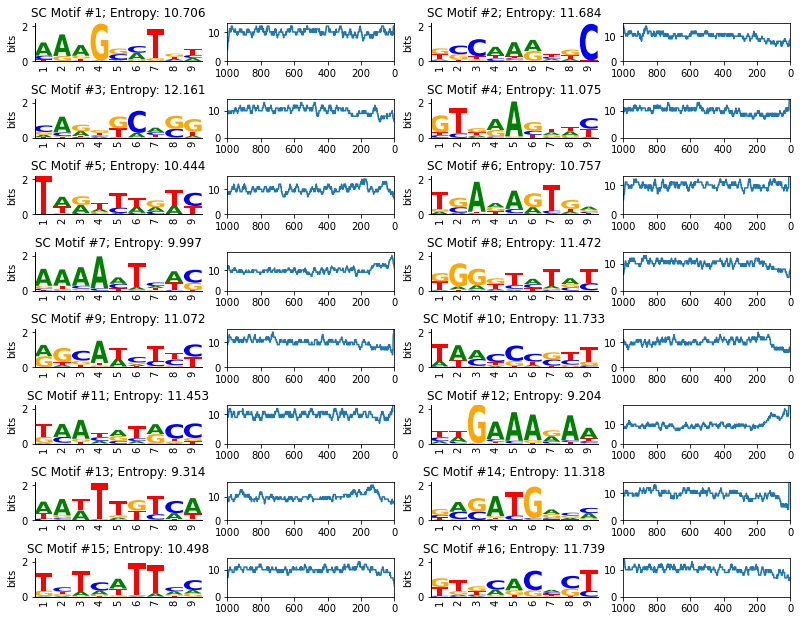

In [53]:
NUM_PER_PAGE = 16

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages(f"sc-elem-promoters-window{window}-smoothed-top{top_k}.pdf") as pdf:
    for page in range((len(promoter_pwms) + NUM_PER_PAGE - 1) // NUM_PER_PAGE):
        start = page * NUM_PER_PAGE
        end = min((page + 1) * NUM_PER_PAGE, len(promoter_pwms))
        
        filter_plots = plot_promoter_filters(
            promoter_pwms, 
            fmap, 
            percentile_cutoff,
            [*range(start, end)], 
            [promoter_entropies[i] for i in range(start, end)]
        )
        pdf.savefig(filter_plots)